In [1]:
!pwd

/notebooks/kaggle-comps


In [2]:
COMPETITION_NAME = 'cifar-10' # replace me

# Kaggle competition bootstrapping
!pip install -qq fastai
!pip install -qq kaggle

from fastai.imports import *
np.set_printoptions(linewidth=130)

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

# get competition data
if iskaggle:
    path = Path('../input/'+COMPETITION_NAME)
else:
    DOWNLOADS = Path('downloads')
    import zipfile,kaggle
    path = DOWNLOADS / COMPETITION_NAME
    if not path.is_dir():
        kaggle.api.competition_download_cli(COMPETITION_NAME, path=DOWNLOADS)
        zipfile.ZipFile(f'{path}.zip').extractall(path)
print('done')

done


## Data preprocessing

In [3]:
df = pd.read_csv(path/'trainLabels.csv')
df.head()

,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile


In [4]:
df.label.value_counts()

frog          5000
truck         5000
deer          5000
automobile    5000
bird          5000
horse         5000
ship          5000
cat           5000
dog           5000
airplane      5000
Name: label, dtype: int64

In [5]:
# let's just get the data from fastai
from fastai.vision.all import *

path = untar_data(URLs.CIFAR)

In [6]:
!ls {path}

labels.txt  test  train


In [7]:
!cat {path/'labels.txt'}

airplane
automobile
bird
cat
deer
dog
frog
horse
ship
truck


In [8]:
files = get_image_files(path/'train')
len(files)

50000

In [9]:
dls = ImageDataLoaders.from_folder(path/'train', valid_pct=0.25)
print(len(dls.train), len(dls.valid))
xs, ys = dls.train.one_batch()
xs.shape, ys.shape

585 196


(torch.Size([64, 3, 32, 32]), torch.Size([64]))

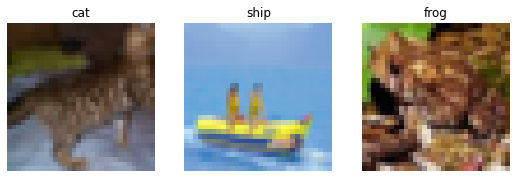

In [10]:
dls.show_batch(max_n=3)

In [41]:
learn = vision_learner(dls, resnet34, metrics=[error_rate, accuracy])
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,3.073412,2.416688,0.817760,00:24


epoch,train_loss,valid_loss,error_rate,time
0,2.860785,2.319537,0.805840,00:28
1,2.581933,2.186736,0.764480,00:28


KeyboardInterrupt: 

### Let's train a custom pytorch CNN with Dropout! 

In [13]:
import torch.nn as nn

class MultiCNNLinearModel(nn.Module):
    def __init__(self, n_linear=2, in_channels=3, in_size=32*32, cnn_features=32, out_features=10, inner_features=256):
        
        super(MultiCNNLinearModel, self).__init__()
        layers = []
        
        # convolutions
        layers.append(nn.Conv2d(in_channels, cnn_features, kernel_size=3, stride=1, padding=1))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool2d(2, 2))
        
        layers.append(nn.Conv2d(cnn_features, cnn_features*2, kernel_size=3, stride=1, padding=1))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool2d(2, 2))
        #layers.append(nn.Dropout(0.25))
            

        # flatten for linear layers
        layers.append(nn.Flatten())
       
        n_conv = 2
        spatial_scaling = 2**(2*n_conv)
        conv_out_size = int(cnn_features*2*in_size/spatial_scaling)
        
        # linear layers
        layers.append(nn.Linear(conv_out_size, inner_features))
        for i in range(n_linear-1):
            layers.append(nn.Linear(inner_features, inner_features))
        layers.append(nn.Linear(inner_features, out_features))
        self.sequential = nn.Sequential(*layers)

    def forward(self, x):
        x = self.sequential(x)
        return x

In [14]:
model = MultiCNNLinearModel(n_linear=2, in_channels=3, in_size=32*32, cnn_features=64, out_features=10, inner_features=128)
model

MultiCNNLinearModel(
  (sequential): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=8192, out_features=128, bias=True)
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): Linear(in_features=128, out_features=10, bias=True)
  )
)

SuggestedLRs(steep=0.0030199517495930195)

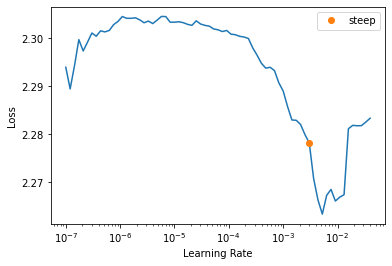

In [15]:
learn = Learner(dls, model, metrics=[accuracy])
learn.lr_find(suggest_funcs=(steep))

In [16]:
learn.fit_one_cycle(8, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.475173,1.439735,0.466080,00:10
1,1.182472,1.126824,0.595520,00:10
2,0.988556,0.986646,0.655200,00:09
3,0.841009,0.924881,0.681120,00:10
4,0.691379,0.841586,0.711680,00:10
5,0.539113,0.850990,0.720000,00:10
6,0.419308,0.853775,0.728960,00:10
7,0.381901,0.856670,0.727840,00:09


### Test predictions

In [18]:
test_files = get_image_files(path/'test')
len(test_files)

10000

In [19]:
test_dl = learn.dls.test_dl(test_files)
preds, _, decoded = learn.get_preds(dl=test_dl, with_decoded=True)

In [21]:
decoded

tensor([9, 9, 8,  ..., 7, 7, 7])